Successfully imported AxonModel_np and nevergrad.
Using device: cpu
Number of training epochs for NN: 5000
Number of neurons (K) for Axon: 500
Filtering NNs with less than 1000 parameters.

Target function: x^2 on range [0.0, 64.0]
Data generated.

Generated 1 NN configurations with >= 1000 parameters.
Starting Axon training for K=500 neurons...
Axon training finished in 605.21s
Axon Final Test MSE: 2.929e-05, Rel L2: 1.658e-03

Starting NN training for 1 configurations...


Training NNs:   0%|          | 0/1 [00:00<?, ?it/s]

Training NN L7_H400_400_400_400_400_400_400_ReLU:   0%|          | 0/5000 [00:00<?, ?it/s]

NN L7_H400_400_400_400_400_400_400_ReLU Final Test MSE: 8.805e-04, Rel L2: 9.089e-03

Plotting results...

--- Final Results (Sorted by Final Test Relative L2 Error) ---
1. Axon (K=500) | K: 500 | TestRelL2: 1.658e-03 | TestMSE: 2.929e-05 | BestTrainMSE: 1.325e-09 | TrainTime: 605.2s | InfTime: 6504.7us
2. L7_H400_400_400_400_400_400_400_ReLU | Params: 963601 | TestRelL2: 9.089e-03 | TestMSE: 8.805e-04 | BestTrainMSE: 8.097e-04 | TrainTime: 190.0s | InfTime: 354.2us


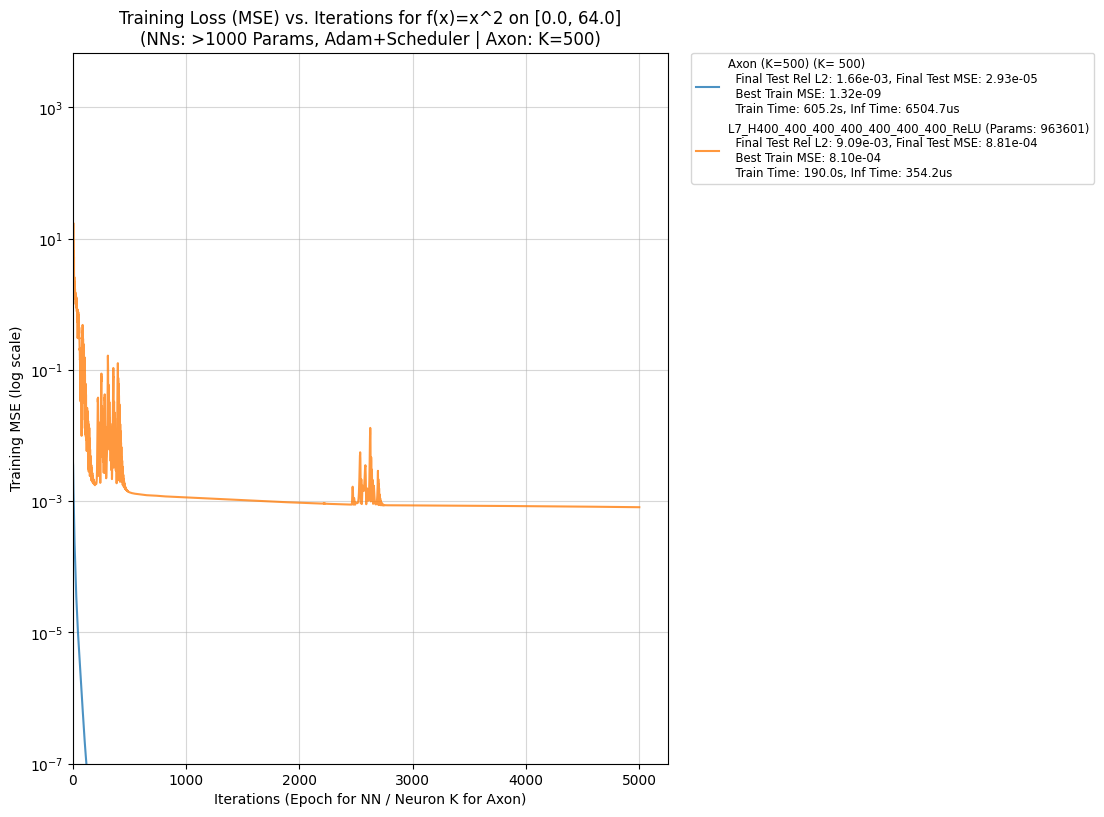

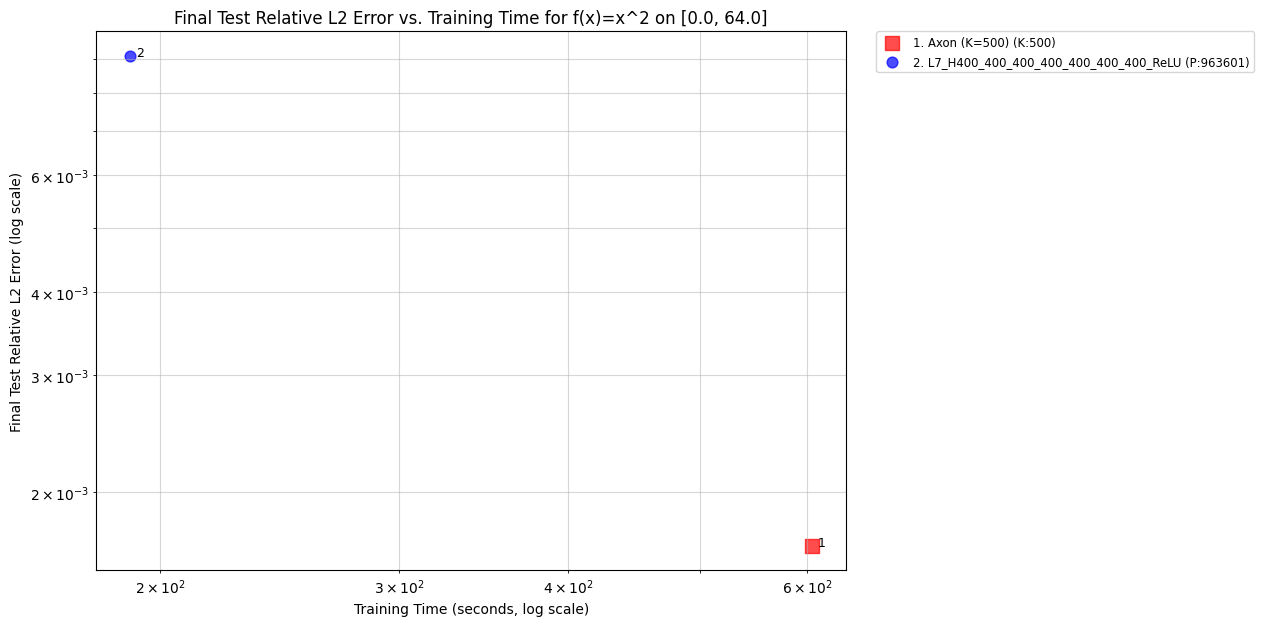


========== Experiment Finished ==========


In [1]:
# === Необходимые импорты ===
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import collections
import copy
import sys  # Для добавления пути

# --- Попытка добавить текущую директорию в путь для импорта ---
# Это нужно, если файлы axon_*.py лежат рядом со скриптом
import os

current_dir = (
    os.path.dirname(os.path.abspath(__file__))
    if "__file__" in locals()
    else os.getcwd()
)
if current_dir not in sys.path:
    sys.path.append(current_dir)
# -------------------------------------------------------------

# --- Импорт кода Axon ---
try:
    # Импортируем класс и функцию nonlinearity из первого файла
    from axon_approximation import AxonModel_np, relu as axon_relu

    # Импортируем nevergrad для оптимизатора Axon
    import nevergrad as ng

    print("Successfully imported AxonModel_np and nevergrad.")
    AXON_AVAILABLE = True
except ImportError as e:
    print(f"--------------------------------------------------------------------")
    print(f"WARNING: Could not import Axon code (axon_aproximation.py or nevergrad).")
    print(f"Error: {e}")
    print(
        f"Axon method will be skipped. Ensure 'axon_aproximation.py' is in the same directory or PYTHONPATH and 'nevergrad' is installed (`pip install nevergrad`)."
    )
    print(f"--------------------------------------------------------------------")
    AXON_AVAILABLE = False
# -------------------------

# Используем tqdm.notebook если в Jupyter, иначе обычный tqdm
try:
    from tqdm.notebook import tqdm

    notebook_env = True
except ImportError:
    from tqdm import tqdm

    notebook_env = False

# === Конфигурация ===
N_SAMPLES = 2000
N_TEST_SAMPLES = 300
NUM_EPOCHS = 5000  # Эпохи для NN
NUM_AXON_NEURONS = 500  # K для Axon
MIN_PARAMS_NN = 1000

DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")
print(f"Number of training epochs for NN: {NUM_EPOCHS}")
if AXON_AVAILABLE:
    print(f"Number of neurons (K) for Axon: {NUM_AXON_NEURONS}")
print(f"Filtering NNs with less than {MIN_PARAMS_NN} parameters.")

# === Целевая функция и диапазон ===
target_func = lambda x:   np.log(
                            1.6 * np.sin(x) +   # Синус
                            0.6 * x +            # Линейная часть
                            np.sqrt(x + 1e-8) + # Корень (с ReLU и малой добавкой)
                            4.0                  # Сдвиг на 1, чтобы аргумент log был > 0
                        )
target_func_name = "x^2"
x_min, x_max = 0, 64.0
print(f"\nTarget function: {target_func_name} on range [{x_min:.1f}, {x_max:.1f}]")

# === Генерация Данных (NumPy float64) ===
x_train_np = np.random.uniform(x_min, x_max, (N_SAMPLES, 1)).astype(np.float64)
y_train_np = target_func(x_train_np).astype(np.float64)
x_test_np = np.linspace(x_min, x_max, N_TEST_SAMPLES).reshape(-1, 1).astype(np.float64)
y_test_np = target_func(x_test_np).astype(np.float64)
norm_y_test_np = np.linalg.norm(y_test_np)
if norm_y_test_np < 1e-9:
    norm_y_test_np = 1.0
print("Data generated.")


# === Класс Нейронной Сети (PyTorch) ===
# (Класс SimpleNN остается без изменений)
class SimpleNN(nn.Module):
    def __init__(
        self, input_size=1, output_size=1, layers_config=None, activation_fn=nn.ReLU()
    ):
        super(SimpleNN, self).__init__()
        self.layers_config = layers_config
        self.activation_fn_name = activation_fn.__class__.__name__
        layers = []
        current_size = input_size
        if layers_config:
            for hidden_size in layers_config:
                layers.append(nn.Linear(current_size, hidden_size))
                layers.append(activation_fn)
                current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def get_config_str(self):
        if not self.layers_config:
            return f"L0_Direct_{self.activation_fn_name}"
        layer_str = "_".join(map(str, self.layers_config))
        return f"L{len(self.layers_config)}_H{layer_str}_{self.activation_fn_name}"

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# === Генерация Конфигураций Сетей (PyTorch) ===
network_configs = {}
# hidden_layer_counts = [1, 2, 3, 4, 5]
# hidden_unit_counts = [16, 32, 64, 128, 256]
hidden_layer_counts = [7]
hidden_unit_counts = [400]
for nl in hidden_layer_counts:
    for hu in hidden_unit_counts:
        layers_cfg = [hu] * nl
        # ReLU
        relu_config = {"layers_config": layers_cfg, "activation_fn": nn.ReLU()}
        temp_model_relu = SimpleNN(**relu_config)
        if temp_model_relu.count_parameters() >= MIN_PARAMS_NN:
            network_configs[temp_model_relu.get_config_str()] = relu_config
        # # Tanh
        # tanh_config = {"layers_config": layers_cfg, "activation_fn": nn.Tanh()}
        # temp_model_tanh = SimpleNN(**tanh_config)
        # if temp_model_tanh.count_parameters() >= MIN_PARAMS_NN:
        #     network_configs[temp_model_tanh.get_config_str()] = tanh_config
print(
    f"\nGenerated {len(network_configs)} NN configurations with >= {MIN_PARAMS_NN} parameters."
)

# === Оптимизатор для NN (PyTorch) ===
optimizer_config_nn = {"name": "Adam", "lr": 0.005}


def get_optimizer_nn(model_params, config):
    name = config["name"]
    lr = config.get("lr", 0.005)
    betas = config.get("betas", (0.9, 0.999))
    return optim.Adam(model_params, lr=lr, betas=betas)


# === Функция Обучения и Оценки для NN (PyTorch) ===
# (train_evaluate_nn остается почти без изменений, только убираем numpy из имен аргументов)
def train_evaluate_nn(
    network_config_name,
    network_params,
    optimizer_config,
    x_train_tensor,
    y_train_tensor,
    x_test_tensor,
    y_test_tensor,
    norm_y_test,
    num_epochs=5000,
    device="cpu",
):
    model = SimpleNN(**network_params).to(device)
    optimizer = get_optimizer_nn(model.parameters(), optimizer_config)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.2, patience=200, min_lr=1e-7
    )
    start_train_time = time.time()
    train_losses_mse = []
    min_train_loss_overall = float("inf")
    for epoch in tqdm(
        range(num_epochs), desc=f"Training NN {network_config_name}", leave=False
    ):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        if torch.isnan(loss):
            print(
                f"NaN loss detected at epoch {epoch} for {network_config_name}. Stopping."
            )
            last_loss = train_losses_mse[-1] if train_losses_mse else float("inf")
            while len(train_losses_mse) < num_epochs:
                train_losses_mse.append(last_loss)
            return None
        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        train_losses_mse.append(current_loss)
        if current_loss < min_train_loss_overall:
            min_train_loss_overall = current_loss
        scheduler.step(current_loss)
    end_train_time = time.time()
    training_time = end_train_time - start_train_time
    model.eval()
    final_test_mse = float("inf")
    final_test_rel_l2 = float("inf")
    try:
        with torch.no_grad():
            y_pred_test = model(x_test_tensor)
            final_test_mse = criterion(y_pred_test, y_test_tensor).item()
            test_norm = torch.linalg.norm(y_test_tensor)
            if test_norm > 1e-9:
                final_test_rel_l2 = (
                    torch.linalg.norm(y_pred_test - y_test_tensor) / test_norm
                ).item()
            else:
                final_test_rel_l2 = torch.linalg.norm(
                    y_pred_test - y_test_tensor
                ).item()
    except Exception as e:
        print(f"Error during final NN eval for {network_config_name}: {e}")
    avg_inference_time = float("inf")
    try:
        single_x_test = x_test_tensor[0:1].to(device)
        n_inference_runs = 100
        with torch.no_grad():
            _ = model(single_x_test)
        inf_start = time.time()
        for _ in range(n_inference_runs):
            with torch.no_grad():
                _ = model(single_x_test)
        inf_end = time.time()
        avg_inference_time = (inf_end - inf_start) / n_inference_runs
    except Exception as e:
        print(f"Error during NN inference timing for {network_config_name}: {e}")
    return {
        "name": network_config_name,
        "type": "NN",
        "train_losses_mse": train_losses_mse,
        "min_train_loss_overall": min_train_loss_overall,
        "final_test_mse": final_test_mse,
        "final_relative_l2_test": final_test_rel_l2,
        "training_time": training_time,
        "avg_inference_time": avg_inference_time,
        "num_params": model.count_parameters(),
    }


# === Запуск Экспериментов ===
all_results = []

# --- Обучение Axon (если импортировался) ---
if AXON_AVAILABLE:
    axon_model = AxonModel_np(nonlinearity=axon_relu)  # Используем импортированный relu
    try:
        # Обучаем Axon
        axon_train_rel_l2_list = axon_model.train(x_train_np, y_train_np, K=NUM_AXON_NEURONS, new_obj=True)
        # Проверка на пустой результат (если train прервался)
        if not isinstance(axon_train_rel_l2_list, list) or not axon_train_rel_l2_list:
            print("Axon training did not return a valid list of errors. Setting defaults.")
            axon_train_rel_l2_list = [float('inf')] * NUM_AXON_NEURONS
            axon_train_mse_list = [float('inf')] * NUM_AXON_NEURONS
        else:
            # Оценка MSE из Rel L2 (грубая)
            # Используем средний квадрат y на ТРЕНИРОВОЧНОЙ выборке для оценки масштаба
            mean_sq_y_train = np.mean(y_train_np**2)
            axon_train_mse_list = [(rel_err**2) * mean_sq_y_train for rel_err in axon_train_rel_l2_list]
            # Убедимся, что длина списка равна NUM_AXON_NEURONS
            if len(axon_train_mse_list) < NUM_AXON_NEURONS:
                last_mse = axon_train_mse_list[-1] if axon_train_mse_list else float('inf')
                axon_train_mse_list.extend([last_mse] * (NUM_AXON_NEURONS - len(axon_train_mse_list)))
            elif len(axon_train_mse_list) > NUM_AXON_NEURONS:
                axon_train_mse_list = axon_train_mse_list[:NUM_AXON_NEURONS] # Обрежем, если длиннее

        # --- Далее код для оценки на тесте и создания axon_result ---
        # (Остается как был, но теперь у нас есть axon_train_mse_list)
        y_pred_axon_test = axon_model.forward(x_test_np)
        axon_final_test_mse = np.mean((y_pred_axon_test - y_test_np)**2)
        # Финальную относительную ошибку берем из последней точки списка или пересчитываем
        axon_final_rel_l2 = np.linalg.norm(y_pred_axon_test - y_test_np) / norm_y_test_np
        axon_inf_time = axon_model.get_inference_time(x_test_np[0:1,:])

        axon_result = {
            "name": f"Axon (K={NUM_AXON_NEURONS})",
            "type": "Axon",
            "train_losses_mse": axon_train_mse_list, # Используем оцененный MSE
            "min_train_loss_overall": min(axon_train_mse_list) if axon_train_mse_list else float('inf'),
            "final_test_mse": axon_final_test_mse,
            "final_relative_l2_test": axon_final_rel_l2,
            "training_time": axon_model.training_time,
            "avg_inference_time": axon_inf_time,
            "num_params": NUM_AXON_NEURONS
        }
        all_results.append(axon_result)
        print(f"Axon Final Test MSE: {axon_final_test_mse:.3e}, Rel L2: {axon_final_rel_l2:.3e}")
    except Exception as e:
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"ERROR during Axon Training or Evaluation: {e}")
        print(f"Axon method will be skipped in the results.")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


# --- Обучение Нейронных Сетей (Adam) ---
print(f"\nStarting NN training for {len(network_configs)} configurations...")
x_train_tensor = torch.from_numpy(x_train_np.astype(np.float32)).to(DEVICE)
y_train_tensor = (
    torch.from_numpy(y_train_np.astype(np.float32)).reshape(-1, 1).to(DEVICE)
)  # Убедимся что y (N, 1)
x_test_tensor = torch.from_numpy(x_test_np.astype(np.float32)).to(DEVICE)
y_test_tensor = (
    torch.from_numpy(y_test_np.astype(np.float32)).reshape(-1, 1).to(DEVICE)
)  # Убедимся что y (N, 1)
norm_y_test_tensor = torch.linalg.norm(y_test_tensor)
if norm_y_test_tensor < 1e-9:
    norm_y_test_tensor = torch.tensor(1.0, device=DEVICE)

for net_name, net_params in tqdm(network_configs.items(), desc="Training NNs"):
    result_nn = train_evaluate_nn(
        net_name,
        net_params,
        optimizer_config_nn,
        x_train_tensor,
        y_train_tensor,
        x_test_tensor,
        y_test_tensor,
        norm_y_test_tensor,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
    )
    if result_nn is not None:
        all_results.append(result_nn)
        print(
            f"NN {net_name} Final Test MSE: {result_nn['final_test_mse']:.3e}, Rel L2: {result_nn['final_relative_l2_test']:.3e}"
        )


# === Построение Графиков ===
if not all_results:
    print("\nNo results to plot. Exiting.")
    exit()

print("\nPlotting results...")
sorted_results = sorted(all_results, key=lambda x: x["final_relative_l2_test"])

# --- График 1: Обучающая Ошибка (MSE) ---
plt.figure(figsize=(14, 9))  # Сделаем чуть выше для заголовка
print(f"\n--- Final Results (Sorted by Final Test Relative L2 Error) ---")
for i, data in enumerate(sorted_results):
    name = data["name"]
    final_test_rel_l2 = data["final_relative_l2_test"]
    final_test_mse = data["final_test_mse"]
    min_train_mse = data["min_train_loss_overall"]
    train_time_s = data["training_time"]
    inf_time_us = data["avg_inference_time"] * 1e6
    params = data["num_params"]
    label = (
        f"{name} ({'Params:' if data['type']=='NN' else 'K='} {params})\n"
        f"  Final Test Rel L2: {final_test_rel_l2:.2e}, Final Test MSE: {final_test_mse:.2e}\n"
        f"  Best Train MSE: {min_train_mse:.2e}\n"
        f"  Train Time: {train_time_s:.1f}s, Inf Time: {inf_time_us:.1f}us"
    )
    print(
        f"{i+1}. {name} | {'Params' if data['type']=='NN' else 'K'}: {params} | TestRelL2: {final_test_rel_l2:.3e} | TestMSE: {final_test_mse:.3e} | BestTrainMSE: {min_train_mse:.3e} | TrainTime: {train_time_s:.1f}s | InfTime: {inf_time_us:.1f}us"
    )
    if data["train_losses_mse"]:
        x_axis = np.arange(1, len(data["train_losses_mse"]) + 1)
        plt.plot(x_axis, data["train_losses_mse"], label=label, alpha=0.8)
    else:
        print(f"Skipping plot for {name} due to empty loss data.")

plt.yscale("log")
plt.title(
    f"Training Loss (MSE) vs. Iterations for f(x)={target_func_name} on [{x_min:.1f}, {x_max:.1f}]\n(NNs: >{MIN_PARAMS_NN} Params, Adam+Scheduler | Axon: K={NUM_AXON_NEURONS})"
)
plt.xlabel("Iterations (Epoch for NN / Neuron K for Axon)")
plt.ylabel("Training MSE (log scale)")
plt.legend(
    bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.0, fontsize="small"
)
plt.subplots_adjust(right=0.55, top=0.90)  # Отрегулируем правую и верхнюю границу
plt.grid(True, which="both", ls="-", alpha=0.5)
max_iterations_nn = NUM_EPOCHS
max_iterations_axon = NUM_AXON_NEURONS if AXON_AVAILABLE else 0
# Найдем максимальную длину оси X из реально полученных данных
max_len_plot = 0
for data in sorted_results:
    if data["train_losses_mse"]:
        max_len_plot = max(max_len_plot, len(data["train_losses_mse"]))
# Установим предел оси X чуть больше максимальной длины кривой
plt.xlim(0, max_len_plot + int(max_len_plot * 0.05))  # + 5% запаса
plt.ylim(
    bottom=1e-7
)  # Добавим нижний предел для логарифмической шкалы, чтобы избежать ошибок
plt.show()

# --- График 2: Финальная Тестовая Ошибка ---
# Построим график "Финальная Тестовая Относительная L2 Ошибка" vs "Время Тренировки"
plt.figure(figsize=(12, 7))
markers = {"NN": "o", "Axon": "s"}
colors = {"NN": "blue", "Axon": "red"}
sizes = {"NN": 60, "Axon": 100}

for i, data in enumerate(sorted_results):
    plt.scatter(
        data["training_time"],
        data["final_relative_l2_test"],
        label=f"{i+1}. {data['name']} ({'P:' if data['type']=='NN' else 'K:'}{data['num_params']})",
        marker=markers[data["type"]],
        color=colors[
            data["type"]
        ],  # Можно сделать разные цвета для разных сетей, но пока так
        s=sizes[data["type"]],
        alpha=0.7,
    )
    # Добавим номер точки из отсортированного списка для идентификации
    plt.text(
        data["training_time"] * 1.01,
        data["final_relative_l2_test"],
        str(i + 1),
        fontsize=9,
    )


plt.yscale("log")
plt.xscale("log")  # Время тренировки тоже может сильно варьироваться
plt.title(
    f"Final Test Relative L2 Error vs. Training Time for f(x)={target_func_name} on [{x_min:.1f}, {x_max:.1f}]"
)
plt.xlabel("Training Time (seconds, log scale)")
plt.ylabel("Final Test Relative L2 Error (log scale)")
plt.legend(
    bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.0, fontsize="small"
)
plt.subplots_adjust(right=0.75)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()


print(f"\n{'='*10} Experiment Finished {'='*10}")
